In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
tf.__version__

'1.14.0'

### Preparing Data - the imdb dataset

In [2]:
VOCAB_SIZE = 50000

In [3]:
# load the movie comment dataset

imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=VOCAB_SIZE)

In [4]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [5]:
# training data should be sentences, in each sentence, the word has already been mapped into w-bags
print(len(train_data[0]), train_data[0])

218 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [8]:
# padding of the data
train_data = keras.preprocessing.sequence.pad_sequences(
    train_data,
    value = word_index["<PAD>"],
    padding = 'post',
    maxlen = 512
)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data,
    value = word_index["<PAD>"],
    padding = 'post',
    maxlen = 512
)

### Construct Model - with different ways to eliminate overfitting

#### original model

In [9]:
EMB_SIZE = 64

model = keras.Sequential()
model.add(keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE)) # embed the words as a 32D vector
model.add(keras.layers.GlobalAveragePooling1D()) # averaging the word embedings to one single embedding for the sequence
model.add(keras.layers.Dense(EMB_SIZE, activation=tf.nn.relu)) # one layer of dense
model.add(keras.layers.Dense(EMB_SIZE, activation=tf.nn.relu)) # one layer of dense
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

W0821 23:17:59.152020 139727268742976 deprecation.py:506] From /home/charlie/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0821 23:17:59.166728 139727268742976 deprecation.py:506] From /home/charlie/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          3200000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,208,385
Trainable params: 3,208,385
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

W0821 23:17:59.263196 139727268742976 deprecation.py:323] From /home/charlie/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/30
15000/15000 [==============================] - 8s 535us/sample - loss: 0.6912 - acc: 0.5489 - val_loss: 0.6862 - val_acc: 0.6752
Epoch 2/30
15000/15000 [==============================] - 7s 476us/sample - loss: 0.6668 - acc: 0.7075 - val_loss: 0.6319 - val_acc: 0.7743
Epoch 3/30
15000/15000 [==============================] - 7s 495us/sample - loss: 0.5472 - acc: 0.8213 - val_loss: 0.4652 - val_acc: 0.8327
Epoch 4/30
15000/15000 [==============================] - 8s 509us/sample - loss: 0.3526 - acc: 0.8793 - val_loss: 0.3352 - val_acc: 0.8711
Epoch 5/30
15000/15000 [==============================] - 8s 524us/sample - loss: 0.2365 - acc: 0.9186 - val_loss: 0.2921 - val_acc: 0.8861
Epoch 6/30
15000/15000 [==============================] - 7s 485us/sample - loss: 0.1758 - acc: 0.9419 - val_loss: 0.2769 - val_acc: 0.8914
Epoch 7/30
15000/15000 [==============================] - 8s 522us/sample - loss: 0.1338 - acc: 0.9577 - val_l

The overfitting phenomina happens at about epoch 15.

#### Model with l2 Regularization

In [15]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE)) # embed the words as a 32D vector
model2.add(keras.layers.GlobalAveragePooling1D()) # averaging the word embedings to one single embedding for the sequence
model2.add(keras.layers.Dense(EMB_SIZE, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001))) # one layer of dense
model2.add(keras.layers.Dense(EMB_SIZE, activation=tf.nn.relu)) # one layer of dense
model2.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

In [16]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          3200000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 3,208,385
Trainable params: 3,208,385
Non-trainable params: 0
_________________________________________________________________


In [17]:
model2.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [19]:
history2 = model2.fit(partial_x_train,
                      partial_y_train,
                      epochs=30,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/30
15000/15000 [==============================] - 7s 485us/sample - loss: 0.7448 - acc: 0.5238 - val_loss: 0.7311 - val_acc: 0.6599
Epoch 2/30
15000/15000 [==============================] - 7s 481us/sample - loss: 0.7139 - acc: 0.6849 - val_loss: 0.6883 - val_acc: 0.7646
Epoch 3/30
15000/15000 [==============================] - 7s 471us/sample - loss: 0.6222 - acc: 0.7956 - val_loss: 0.5443 - val_acc: 0.8197
Epoch 4/30
15000/15000 [==============================] - 7s 469us/sample - loss: 0.4336 - acc: 0.8683 - val_loss: 0.4047 - val_acc: 0.8530
Epoch 5/30
15000/15000 [==============================] - 7s 475us/sample - loss: 0.3024 - acc: 0.9091 - val_loss: 0.3409 - val_acc: 0.8842
Epoch 6/30
15000/15000 [==============================] - 7s 458us/sample - loss: 0.2350 - acc: 0.9357 - val_loss: 0.3213 - val_acc: 0.8915
Epoch 7/30
15000/15000 [==============================] - 7s 468us/sample - loss: 0.1928 - acc: 0.9506 - val_l

The overfitting phenomina happens at about epoch 18.

#### Model with l2 Regularization

In [34]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE)) # embed the words as a 32D vector
model3.add(keras.layers.GlobalAveragePooling1D()) # averaging the word embedings to one single embedding for the sequence
model3.add(keras.layers.Dense(EMB_SIZE, activation=tf.nn.relu)) # one layer of dense
model3.add(keras.layers.Dropout(0.2)),
model3.add(keras.layers.Dense(EMB_SIZE, activation=tf.nn.relu)) # one layer of dense
model3.add(keras.layers.Dropout(0.2)),
model3.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

In [35]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          3200000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [36]:
model3.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [38]:
history3 = model3.fit(partial_x_train,
                      partial_y_train,
                      epochs=30,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/30
15000/15000 [==============================] - 7s 481us/sample - loss: 0.6921 - acc: 0.5379 - val_loss: 0.6888 - val_acc: 0.6960
Epoch 2/30
15000/15000 [==============================] - 7s 460us/sample - loss: 0.6746 - acc: 0.6768 - val_loss: 0.6449 - val_acc: 0.7812
Epoch 3/30
15000/15000 [==============================] - 7s 453us/sample - loss: 0.5730 - acc: 0.7931 - val_loss: 0.4888 - val_acc: 0.8268
Epoch 4/30
15000/15000 [==============================] - 7s 462us/sample - loss: 0.3846 - acc: 0.8629 - val_loss: 0.3432 - val_acc: 0.8702
Epoch 5/30
15000/15000 [==============================] - 7s 464us/sample - loss: 0.2572 - acc: 0.9059 - val_loss: 0.2915 - val_acc: 0.8853
Epoch 6/30
15000/15000 [==============================] - 7s 451us/sample - loss: 0.1930 - acc: 0.9309 - val_loss: 0.2830 - val_acc: 0.8866
Epoch 7/30
15000/15000 [==============================] - 7s 455us/sample - loss: 0.1475 - acc: 0.9501 - val_l

The overfitting phenomina happens at about epoch 18.

### Evaluate the model

In [39]:
results1 = model.evaluate(test_data, test_labels)
print(results1)

results2 = model2.evaluate(test_data, test_labels)
print(results2)

results3 = model3.evaluate(test_data, test_labels)
print(results3)

25000/25000 [==============================] - 1s 58us/sample - loss: 0.5932 - acc: 0.8658
[0.593247857580185, 0.86584]
25000/25000 [==============================] - 1s 56us/sample - loss: 0.4847 - acc: 0.8632
[0.48467225369930267, 0.86324]
25000/25000 [==============================] - 1s 57us/sample - loss: 0.6376 - acc: 0.8664
[0.637641857098341, 0.86636]


In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

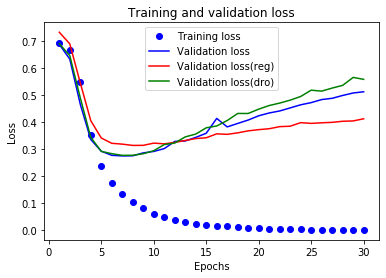

In [41]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss(reg)')
plt.plot(epochs, val_loss3, 'g', label='Validation loss(dro)')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()